## Waste Water Plots for Jake ##

In [3]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

In [101]:
# mesh mask file for land mask
meshmask = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = meshmask.tmask[0]
tmask = tmask.rename({'z': 'deptht'})
e3t = meshmask.e3t_1d[0]
e3t = e3t.rename({'z': 'deptht'})
area = meshmask.e1t[0] * meshmask.e2t[0]

In [5]:
# make land versions of cmaps, land is grey
cm_salt = copy.copy(cm.haline)
cm_salt.set_bad('grey')
cm_bwr = copy.copy(cm.balance)
cm_bwr.set_bad('grey')
cm_temp = copy.copy(cm.thermal)
cm_temp.set_bad('grey')

In [6]:
## No outfall file
base = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/base_again/SalishSea_1h_20230301_20230301_grid_T.nc')

In [7]:
## With clean freshwater outfall
tands = xr.open_dataset('/data/sallen/results/MEOPAR/wastewater/tands//SalishSea_1h_20230301_20230301_grid_T.nc')

In [82]:
## plan view 
def planview(base, new, field, it, ide, cmap, vmax, vmin, dvmax):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    iz = 30  # width of domain plotted
    y_slice=slice(400+iz, 500-iz)
    x_slice=slice(250+iz, 350-iz)

    (base[field]
	.isel(time_counter=it, deptht=ide, y=y_slice, x=x_slice)
	.where(tmask.isel(z=ide, y=y_slice, x=x_slice))
	.plot(ax=axs[0], cmap=cmap, vmax=vmax, vmin=vmin))

    axs[0].set_title(f'Base {field}')

    new[field][it, ide, 400+iz:500-iz, 250+iz:350-iz].where(
        tmask[ide, 400+iz:500-iz, 250+iz:350-iz]).plot(ax=axs[1], cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(f'New {field}')
    
    (new[field][it, ide, 400+iz:500-iz, 250+iz:350-iz]-
     base[field][it, ide, 400+iz:500-iz, 250+iz:350-iz]).where(
        tmask[ide, 400+iz:500-iz, 250+iz:350-iz]).plot(ax=axs[2], cmap=cm_bwr, 
                                                              vmax=dvmax, vmin=-dvmax)
    axs[2].set_title(f'Difference (New-Base) {field}')

    for ax in axs:
        viz_tools.set_aspect(ax)

    fig.suptitle(f'Depth {base.deptht[ide].values:.0f} m')

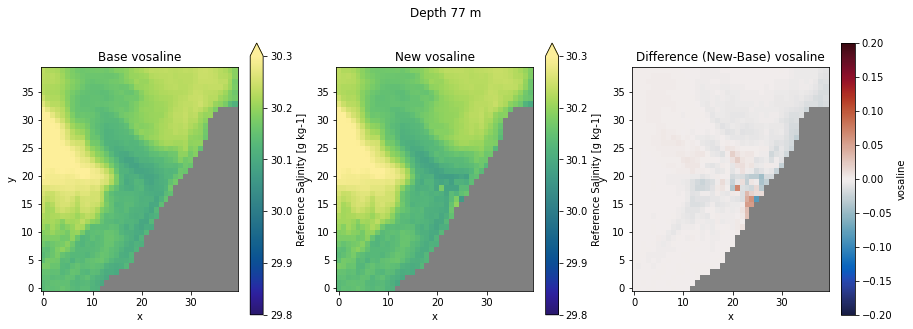

In [83]:
planview(base, tands, 'vosaline', 23, 25, cm_salt, 30.3, 29.8, 0.2)

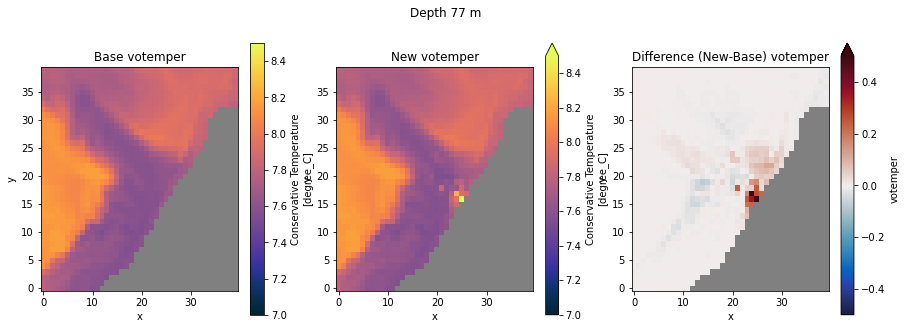

In [78]:
planview(base, tands, 'votemper', 23, 25, cm_temp, 8.5, 7, 0.5)

In [138]:
def get_uv(dir, it, ide, x_slice, y_slice):
    # read in both the u and v velocity components
    base_u = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_U.nc')
    base_v = xr.open_dataset(f'/data/sallen/results/MEOPAR/wastewater/{dir}/SalishSea_1h_20230301_20230301_grid_V.nc')

# the u velocity is staggered in the x direction, unstagger it
    u_region = viz_tools.unstagger_xarray(
        base_u.vozocrtx.isel(time_counter=it, depthu=ide, y=y_slice, x=x_slice), 'x')

# the v velocity is staggered in the y direction, unstagger it
    v_region = viz_tools.unstagger_xarray(
        base_v.vomecrty.isel(time_counter=it, depthv=ide, y=y_slice, x=x_slice), 'y')

# merge u and v into one dataset, dropping the now inaccurate nav_lon and nav_lat varaiables
    base_uv = xr.merge([u_region.rename({'depthu': 'deptht'}).drop(['nav_lon', 'nav_lat']), 
                    v_region.rename({'depthv': 'deptht'}).drop(['nav_lon', 'nav_lat'])])

# give x and y there own coordinate names
    base_uv = base_uv.assign(grid_X=lambda alpha: alpha.x)
    base_uv = base_uv.assign(grid_Y=lambda alpha: alpha.y)

    return base_uv

In [199]:
def plot_w_quiver(base_dir, base, new_dir, new, field, it, ide, cmap, vmax, vmin, dvmax):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    step = 3
    
    iz = 30  # width of domain plotted
    y_slice=slice(400+iz, 500-iz)
    x_slice=slice(250+iz, 350-iz)
    
    (base[field]
     .isel(time_counter=it, deptht=ide, y=y_slice, x=x_slice)
     .where(tmask.isel(z=ide, y=y_slice, x=x_slice))
    	.plot(ax=axs[0], cmap=cmap, vmax=vmax, vmin=vmin));
    
    base_uv = get_uv(base_dir, it, ide, x_slice, y_slice)
    
    (base_uv
     .isel(x=slice(None, None, step), y=slice(None, None,step))
     .plot.quiver(x='grid_X', y='grid_Y', u='vozocrtx', v='vomecrty', 
                        pivot='mid', ax=axs[0]));

    bigarrow2 = (base_uv.vozocrtx**2 + base_uv.vomecrty**2).max().values
    axs[0].text(20, 5, f'Max vel {np.sqrt(bigarrow2):.2f} m/s')

    (new[field]
     .isel(time_counter=it, deptht=ide, y=y_slice, x=x_slice)
     .where(tmask.isel(z=ide, y=y_slice, x=x_slice))
    	.plot(ax=axs[1], cmap=cmap, vmax=vmax, vmin=vmin));

    new_uv = get_uv(new_dir, it, ide, x_slice, y_slice)

    (new_uv
     .isel(x=slice(None, None, step), y=slice(None, None,step))
     .plot.quiver(x='grid_X', y='grid_Y', u='vozocrtx', v='vomecrty', 
                        pivot='mid', ax=axs[1]));

    bigarrow2 = (new_uv.vozocrtx**2 + new_uv.vomecrty**2).max().values
    axs[1].text(20, 5, f'Max vel {np.sqrt(bigarrow2):.2f} m/s')

    ((new[field]
     .isel(time_counter=it, deptht=ide, y=y_slice, x=x_slice)
     - base[field]
     .isel(time_counter=it, deptht=ide, y=y_slice, x=x_slice))
     .where(tmask.isel(z=ide, y=y_slice, x=x_slice))
    	.plot(ax=axs[2], cmap=cm_bwr, vmax=dvmax, vmin=-dvmax))

    diff = new_uv - base_uv
    # reset grid_X and grid_Y as they are now all zero
    diff = diff.assign(grid_X=lambda alpha: alpha.x)
    diff = diff.assign(grid_Y=lambda alpha: alpha.y)
    
    (diff
     .isel(x=slice(None, None, step), y=slice(None, None,step))
     .plot.quiver(x='grid_X', y='grid_Y', u='vozocrtx', v='vomecrty', 
                        pivot='mid', scale=0.5, ax=axs[2]));

    bigarrow2 = (diff.vozocrtx**2 + diff.vomecrty**2).max().values
    axs[2].text(20, 5, f'Max vel {np.sqrt(bigarrow2):.2f} m/s')
    
    for ax in axs:
        viz_tools.set_aspect(ax)

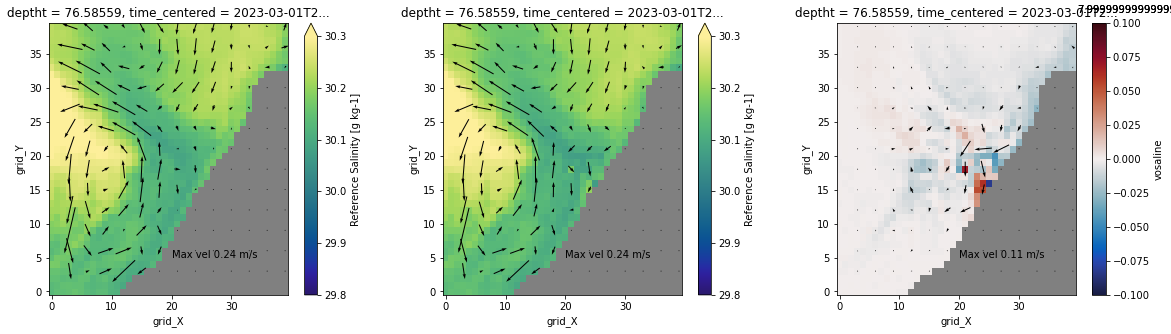

In [200]:
plot_w_quiver('base_again', base, 'tands', tands, 'vosaline', 23, 25, cm_salt, 30.3, 29.8, 0.1)

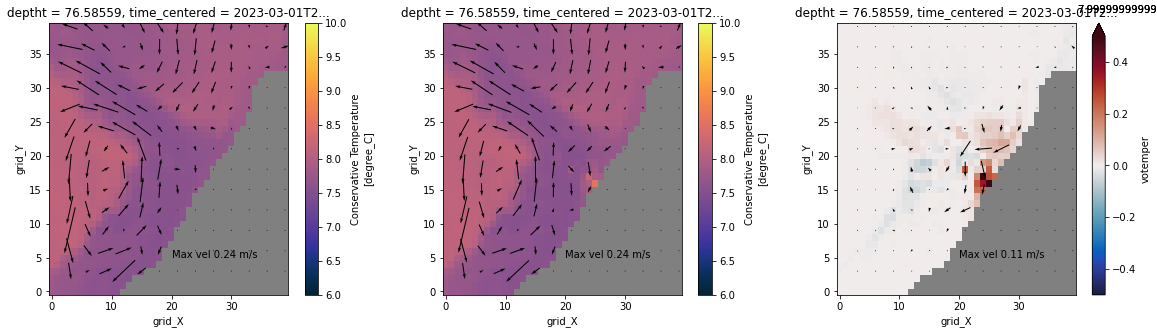

In [203]:
plot_w_quiver('base_again', base, 'tands', tands, 'votemper', 23, 25, cm_temp, 10, 6, 0.5)

In [42]:
iz = 30
y_slice=slice(400+iz, 500-iz)
x_slice=slice(250+iz, 350-iz)
jake_sum = (base.votemper.sel(y=y_slice, x=x_slice)
            .where(tmask.isel(y=y_slice, x=x_slice))
            .mean(dim= ["y", "x"]))
new_sum = (tands.votemper.sel(y=y_slice, x=x_slice)
            .where(tmask.isel(y=y_slice, x=x_slice))
            .mean(dim= ["y", "x"]))

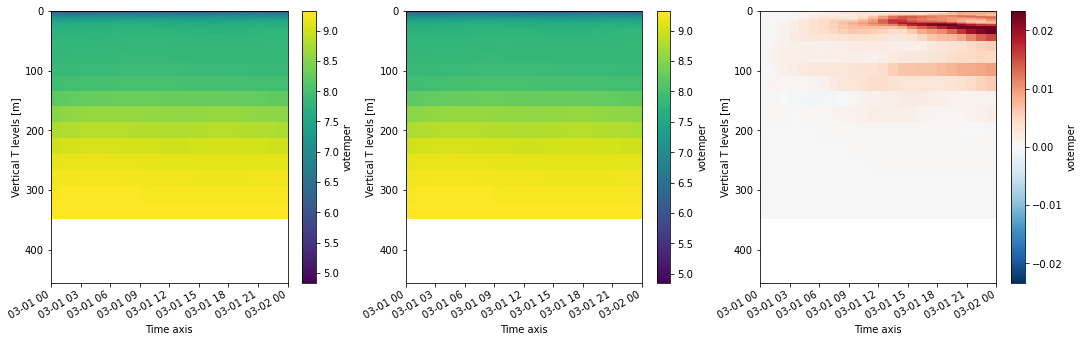

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
jake_sum.transpose().plot(ax=axs[0], yincrease=False)
new_sum.transpose().plot(ax=axs[1], yincrease=False)
(new_sum - jake_sum).transpose().plot(ax=axs[2], yincrease=False)

In [80]:
iz = -100
y_slice=slice(400+iz, 500-iz)
x_slice=slice(250+iz, max(350-iz, 398))
jake_sum = (base.vosaline.sel(y=y_slice, x=x_slice)
            .where(tmask.isel(y=y_slice, x=x_slice))
            .sum(dim= ["y", "x"]))
new_sum = (tands.vosaline.sel(y=y_slice, x=x_slice)
            .where(tmask.isel(y=y_slice, x=x_slice))
            .sum(dim= ["y", "x"]))

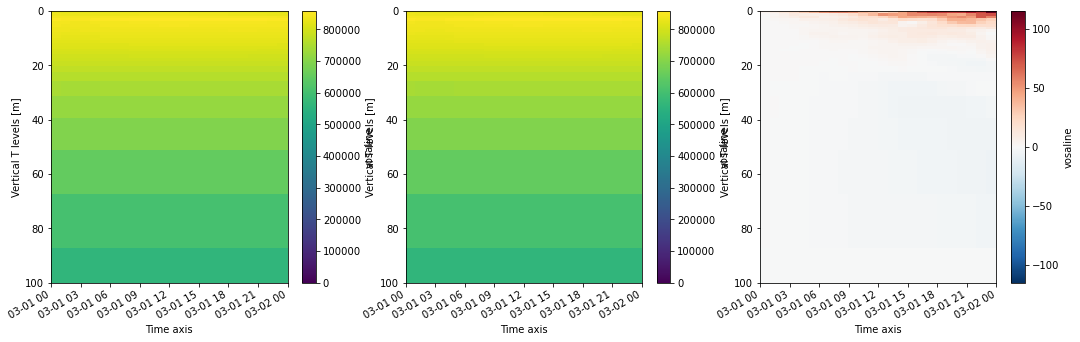

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
jake_sum.transpose().plot(ax=axs[0], yincrease=False)
new_sum.transpose().plot(ax=axs[1], yincrease=False)
(new_sum - jake_sum).transpose().plot(ax=axs[2], yincrease=False)
for ax in axs:
    ax.set_ylim((100, 0))

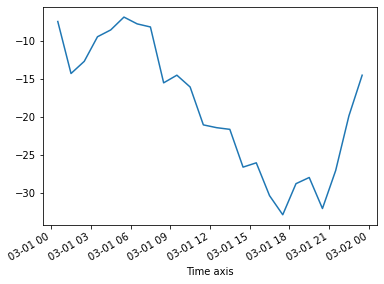

In [82]:
(((new_sum - jake_sum) * e3t).sum(axis=1)).plot()

In [87]:
jake_vertical = (base.vosaline * e3t).sum(axis=1)

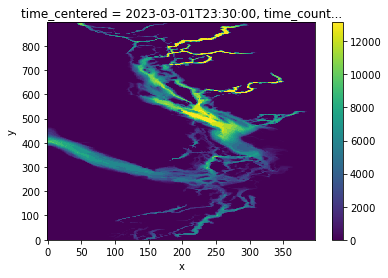

In [90]:
jake_vertical[23].plot();

In [92]:
new_vertical = (tands.vosaline * e3t).sum(axis=1)

-1.9963045836105513 million


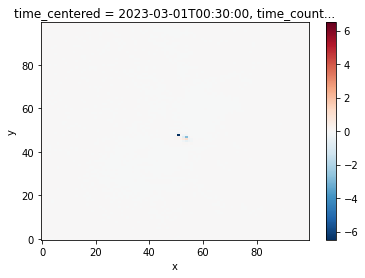

In [106]:
it = 0
imin, imax = 400, 500
jmin, jmax = 250, 350
(new_vertical[it, imin:imax, jmin:jmax] - jake_vertical[it, imin:imax, jmin:jmax]).plot();
print (((new_vertical[it] - jake_vertical[it])*area).sum().values/1e6, 'million')

-2.860758967208147 million


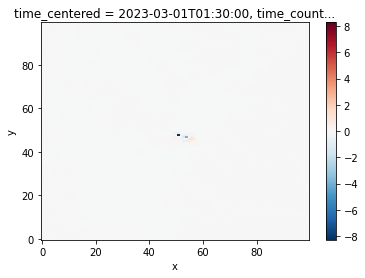

In [104]:
it = 1
imin, imax = 400, 500
jmin, jmax = 250, 350
(new_vertical[it, imin:imax, jmin:jmax] - jake_vertical[it, imin:imax, jmin:jmax]).plot();
print (((new_vertical[it] - jake_vertical[it])*area).sum().values/1e6, 'million')

-2.8877484216744085 million


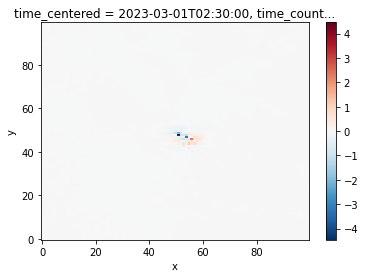

In [105]:
it = 2
imin, imax = 400, 500
jmin, jmax = 250, 350
(new_vertical[it, imin:imax, jmin:jmax] - jake_vertical[it, imin:imax, jmin:jmax]).plot();
print (((new_vertical[it] - jake_vertical[it])*area).sum().values/1e6, 'million')

-2.409777506881804 million


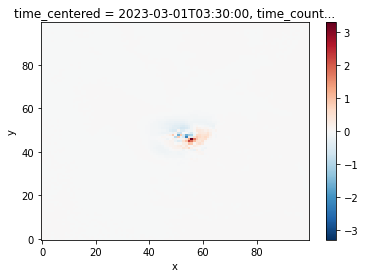

In [107]:
it = 3
imin, imax = 400, 500
jmin, jmax = 250, 350
(new_vertical[it, imin:imax, jmin:jmax] - jake_vertical[it, imin:imax, jmin:jmax]).plot();
print (((new_vertical[it] - jake_vertical[it])*area).sum().values/1e6, 'million')

-25.98747356802023


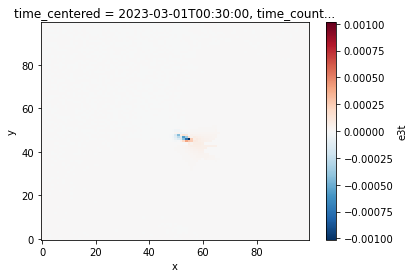

In [125]:
it = 0
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

-2.0448375526568667


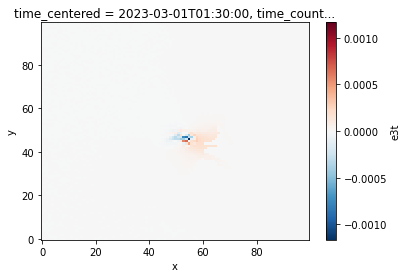

In [124]:
it = 1
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

13.683283391097842


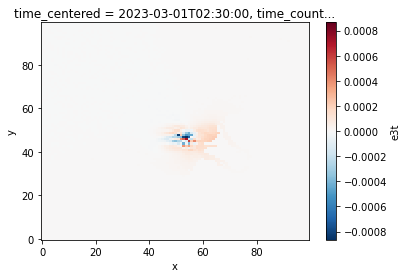

In [123]:
it = 2
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

246.49604527461335


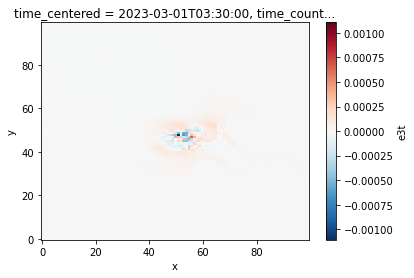

In [126]:
it = 3
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

328.75315810131644


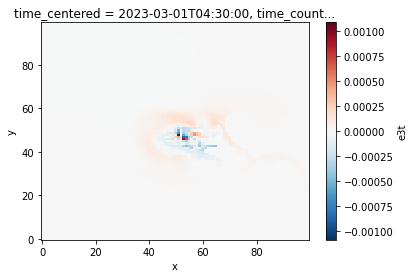

In [127]:
it = 4
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

-4834.186604372357


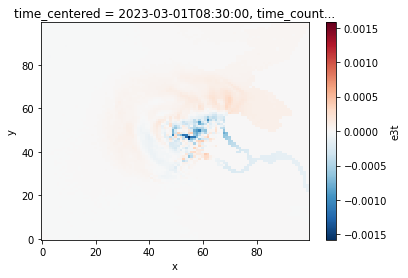

In [128]:
it = 8
imin, imax = 400, 500
jmin, jmax = 250, 350
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot()
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

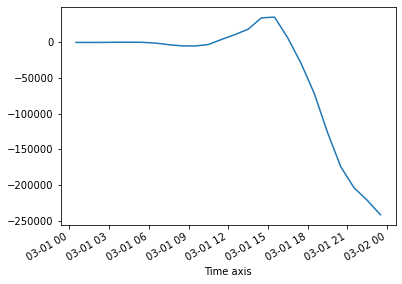

In [129]:
(((tands.e3t - base.e3t)*area).sum(axis=1).sum(axis=1).sum(axis=1)).plot();

246.49604527461335


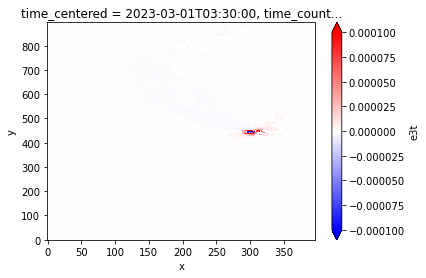

In [145]:
it = 3
imin, imax = 400, 500
jmin, jmax = 250, 350
imin, imax = 0, -1
jmin, jmax = 0, -1
(tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax]).sum(axis=0).plot( vmax=0.0001, vmin=-0.0001, 
                                                                                                 cmap = 'bwr')
print (((tands.e3t[it] - base.e3t[it])*area).sum().values)

In [137]:
print (((tands.e3t[it, :, imin:imax, jmin:jmax] - base.e3t[it, :, imin:imax, jmin:jmax])
        *area[imin:imax, jmin:jmax]).sum().values)

-1488.8299934034794


In [151]:
12*  (23+0.5) * 3600/1e6

1.0152